Assignment 2 - 2602110986 - Anthonio Obert Lais

In [19]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

In [20]:
def resize_image(image, scale= 0.5):

    # Rescale because run out of memory
    height, width = image.shape[:2] # (height, width, channels)
    resize = (int(width * scale), int(height * scale))
    
    return cv.resize(image, resize)

In [21]:
# Load images

directory_path = './dataset/'

pair_1 = []
pair_2 = []

for folder in os.listdir(directory_path):
    
    folder_path = os.path.join(directory_path, folder)

    for file in os.listdir(folder_path):

        file_path = os.path.join(folder_path, file)

        image = cv.imread(file_path, cv.IMREAD_GRAYSCALE)
        resized_image = resize_image(image, scale=0.5)

        if(folder == 'pair_1'):
            pair_1.append(image)
        else:
            pair_2.append(image)

print(pair_1)


[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([[156, 156, 156, ..., 203, 203, 203],
       [156, 156, 156, ..., 203, 203, 203],
       [156, 156, 156, ..., 203, 203, 

In [22]:
def useORBDescriptorBFMatcher(pair_1 : list, pair_2 : list):

    orb = cv.ORB_create()
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

    n = len(pair_1)

    plt.figure(figsize=(15, 4 * n)) 

    for idx in range(n):

        keypoint_1, descriptor_1 = orb.detectAndCompute(pair_1[idx], None)
        keypoint_2, descriptor_2 = orb.detectAndCompute(pair_2[idx], None)

        matches = bf.match(descriptor_1, descriptor_2)
        matches = sorted(matches, key= lambda x: x.distance)

        # Get first 20 matches based on order of distance
        draw = cv.drawMatches(pair_1[idx], keypoint_1, pair_2[idx], keypoint_2, matches[:20], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        draw_rgb = cv.cvtColor(draw, cv.COLOR_BGR2RGB)

        plt.subplot(n, 1, idx + 1)
        plt.imshow(draw_rgb)
        plt.axis('off')
        plt.title(f'Pair {idx + 1} | ORB - BF')

    plt.tight_layout()
    plt.show()


useORBDescriptorBFMatcher(pair_1, pair_2)


In [23]:
def useSIFTDescriptorBFMatcher(pair_1 : list, pair_2 : list):

    sift = cv.SIFT_create()
    bf = cv.BFMatcher()

    n = len(pair_1)

    plt.figure(figsize=(15, 4 * n)) 

    for idx in range(n):

        keypoint_1, descriptor_1 = sift.detectAndCompute(pair_1[idx], None)
        keypoint_2, descriptor_2 = sift.detectAndCompute(pair_2[idx], None)

        matches = bf.knnMatch(descriptor_1, descriptor_2, k= 2)


        # Ratio test
        good_matches = []

        for match, dmatch in matches:
            if match.distance < 0.75 * dmatch.distance:
                good_matches.append([match])

        draw = cv.drawMatchesKnn(pair_1[idx], keypoint_1, pair_2[idx], keypoint_2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        draw_rgb = cv.cvtColor(draw, cv.COLOR_BGR2RGB)

        plt.subplot(n, 1, idx + 1)
        plt.imshow(draw_rgb)
        plt.axis('off')
        plt.title(f'Pair {idx + 1} | SIFT - BF')

    plt.tight_layout()
    plt.show()


useSIFTDescriptorBFMatcher(pair_1, pair_2)


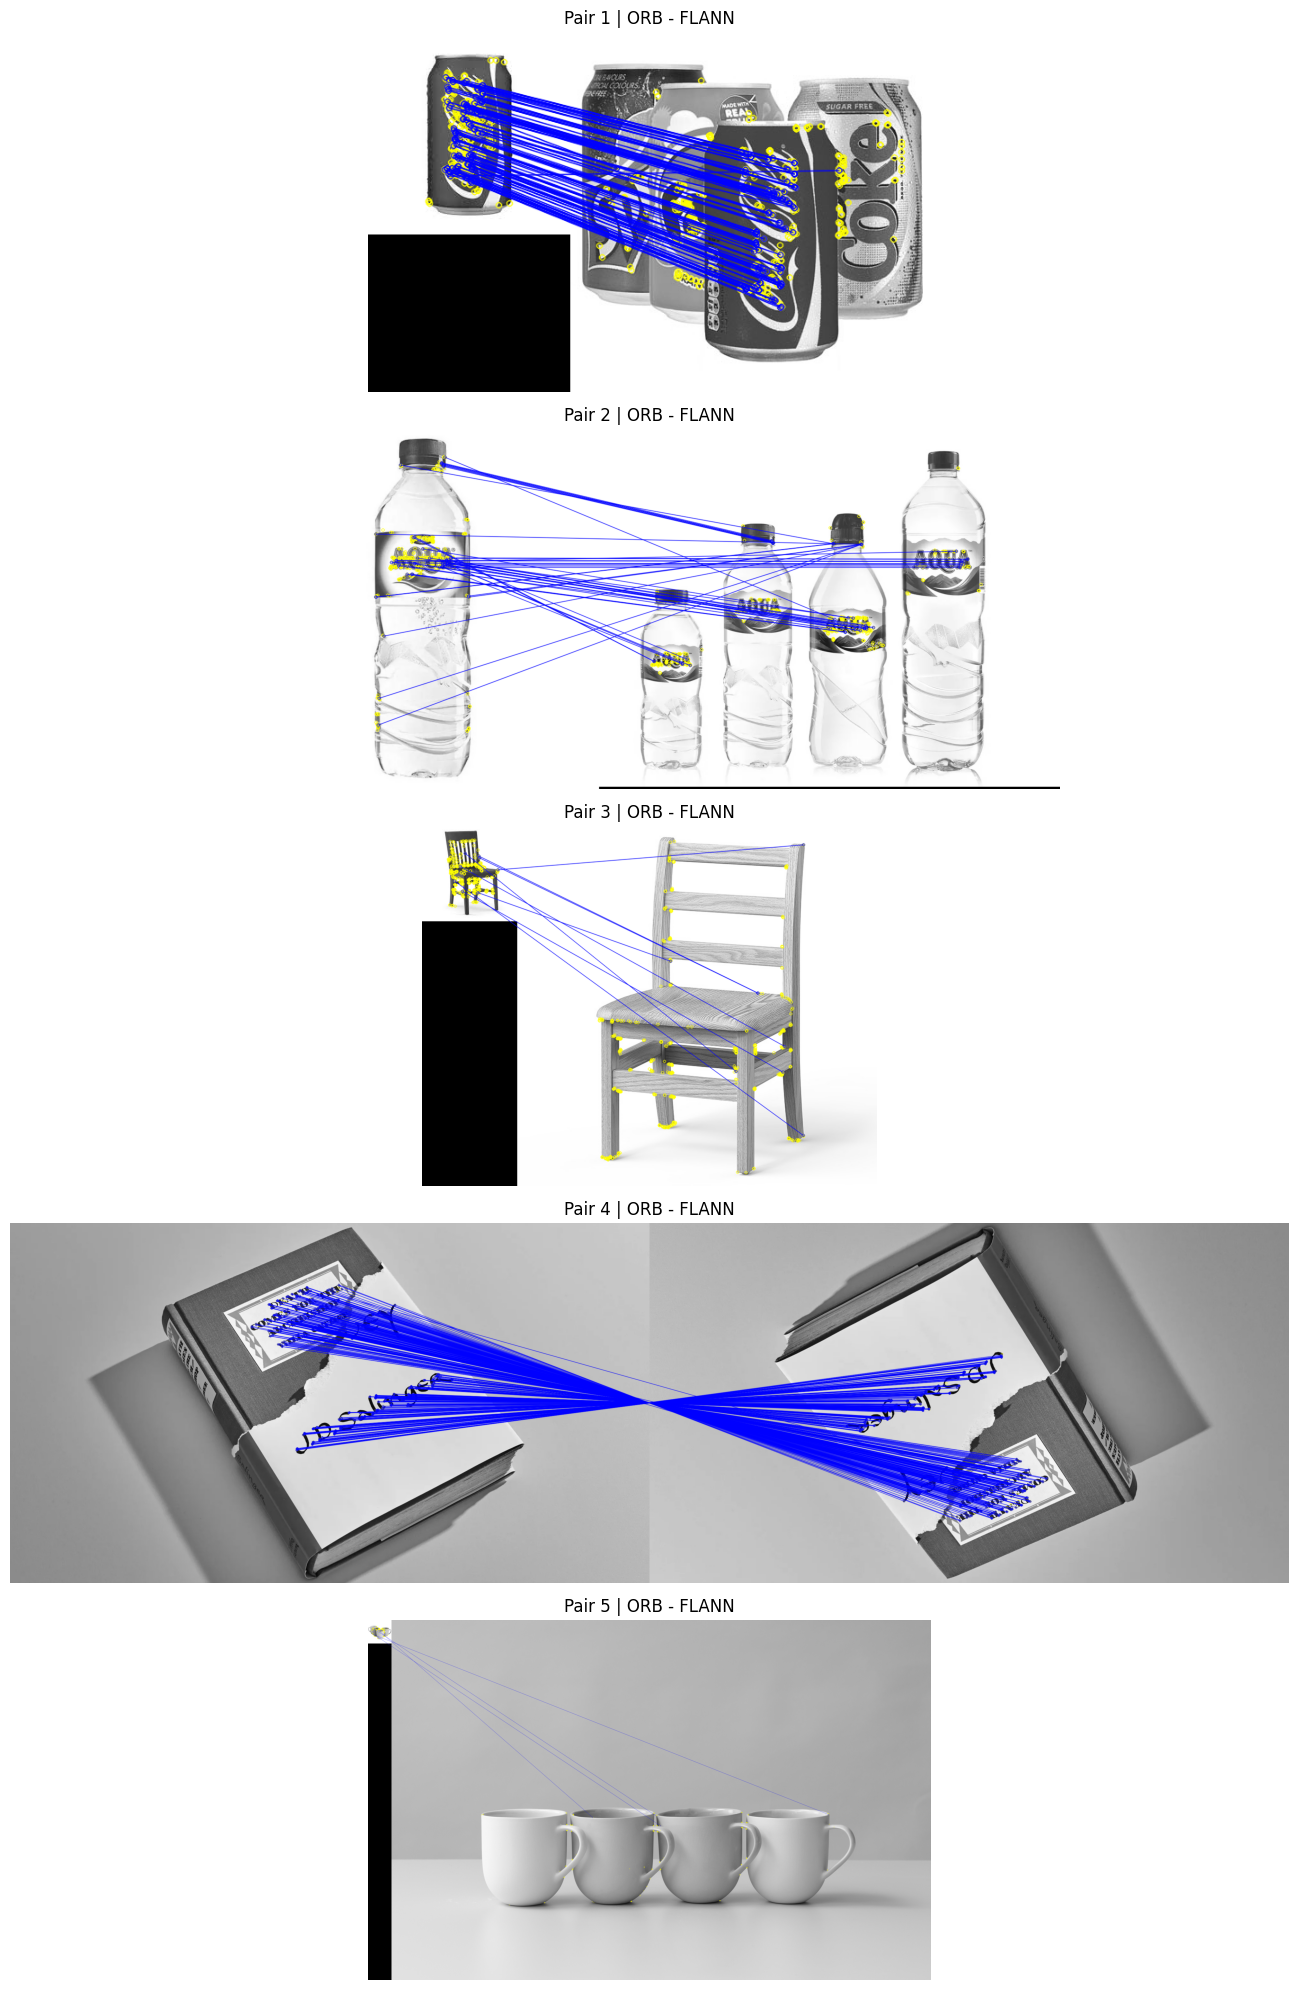

In [24]:
def useORBDescriptorFLANNMatcher(pair_1, pair_2):

    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm = FLANN_INDEX_LSH, table_number = 5, key_size = 12, multi_probe_level = 1)
    search_params = dict(checks= 50)

    orb = cv.ORB_create()
    flann = cv.FlannBasedMatcher(index_params, search_params)

    n = len(pair_1)

    plt.figure(figsize=(15, 4 * n)) 

    for idx in range(n):

        keypoint_1, descriptor_1 = orb.detectAndCompute(pair_1[idx], None)
        keypoint_2, descriptor_2 = orb.detectAndCompute(pair_2[idx], None)

        matches = flann.knnMatch(descriptor_1, descriptor_2, k= 2)

        mask = [[0, 0] for i in range(len(matches))]

        # Ratio test

        for i, match_pair in enumerate(matches):
            if len(match_pair) == 2: 
                match, dmatch = match_pair 
                if match.distance < 0.75 * dmatch.distance:
                    mask[i] = [1, 0]

        draw_params = dict(matchColor = (255, 0, 0), singlePointColor = (0, 255, 255), matchesMask = mask, flags= cv.DrawMatchesFlags_DEFAULT)
        draw = cv.drawMatchesKnn(pair_1[idx], keypoint_1, pair_2[idx], keypoint_2, matches, None, **draw_params)
        draw_rgb = cv.cvtColor(draw, cv.COLOR_BGR2RGB)

        plt.subplot(n, 1, idx + 1)
        plt.imshow(draw_rgb)
        plt.axis('off')
        plt.title(f'Pair {idx + 1} | ORB - FLANN')

    plt.tight_layout()
    plt.show()

useORBDescriptorFLANNMatcher(pair_1, pair_2)

In [25]:
def useSIFTDescriptorFLANNMatcher(pair_1, pair_2):

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks= 50)

    sift = cv.SIFT_create()
    flann = cv.FlannBasedMatcher(index_params, search_params)

    n = len(pair_1)

    plt.figure(figsize=(15, 4 * n)) 

    for idx in range(n):

        keypoint_1, descriptor_1 = sift.detectAndCompute(pair_1[idx], None)
        keypoint_2, descriptor_2 = sift.detectAndCompute(pair_2[idx], None)

        matches = flann.knnMatch(descriptor_1, descriptor_2, k= 2)

        mask = [[0, 0] for i in range(len(matches))]

        # Ratio test

        for i, (match, dmatch) in enumerate(matches):
            if match.distance < 0.75 * dmatch.distance:
                mask[i] = [1, 0]

        draw_params = dict(matchColor = (0, 255, 0), singlePointColor = (255, 0, 0), matchesMask = mask, flags= cv.DrawMatchesFlags_DEFAULT)
        draw = cv.drawMatchesKnn(pair_1[idx], keypoint_1, pair_2[idx], keypoint_2, matches, None, **draw_params)

        plt.subplot(n, 1, idx + 1)
        plt.imshow(draw)
        plt.axis('off')
        plt.title(f'Pair {idx + 1} | SIFT - FLANN')

    plt.tight_layout()
    plt.show()

useSIFTDescriptorFLANNMatcher(pair_1, pair_2)